# Sentiment Analysis Demo

In [1]:
import torch
torch.cuda.is_available()

True

## Data Analysis

In [2]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/labelled_text.csv", encoding = "ISO-8859-1", header=None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
df.shape

(74682, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       74682 non-null  int64 
 1   1       74682 non-null  object
 2   2       74682 non-null  object
 3   3       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


### Analyze columns

In [5]:
df[0].value_counts(dropna=False)

2401    6
6164    6
6141    6
6142    6
6143    6
       ..
4678    6
4679    6
4680    6
4681    6
9200    6
Name: 0, Length: 12447, dtype: int64

In [6]:
df[1].value_counts(dropna=False)

TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)               

In [7]:
# Check available labels
df[2].value_counts(dropna=False)

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: 2, dtype: int64

In [8]:
df = df[df[2] != "Irrelevant"]
df.shape

(61692, 4)

In [9]:
# Rows where the text is missing
print(sum(df[3].isnull()))
print(sum(df[3] == ""))
print(sum(df[3].str.len() == 1))

571
0
290


In [10]:
df.dropna(subset=[3], inplace=True)
df = df[df[3].str.len() > 1]
df.shape

(60831, 4)

In [11]:
def to_id(sentiment):
    if sentiment == "Negative":
        return 0
    elif sentiment == "Neutral":
        return 1
    elif sentiment == "Positive":
        return 2

df[2] = df[2].apply(to_id)

## Prepare Tokenizer

In [12]:
import transformers
from transformers import BertTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
sample_txt = df.loc[0, 3]

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: im getting on borderlands and i will murder you all ,
   Tokens: ['im', 'getting', 'on', 'border', '##lands', 'and', 'i', 'will', 'murder', 'you', 'all', ',']
Token IDs: [13280, 2033, 1113, 3070, 6754, 1105, 178, 1209, 3513, 1128, 1155, 117]


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


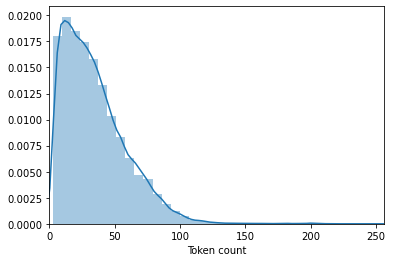

In [14]:
token_lens = []

for txt in df[3]:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [15]:
MAX_LEN = 125

## Create PyTorch Dataset

In [16]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, messages, labels, tokenizer, max_len):
        self.messages = messages
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.messages)
    
    def __getitem__(self, item):
        message = str(self.messages[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            message,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            #pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
          'message': message,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [17]:
from sklearn.model_selection import train_test_split

SEED = 0

df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=SEED)

df_train.shape, df_val.shape, df_test.shape

((48664, 4), (6083, 4), (6084, 4))

In [18]:
train_dataset = SentimentDataset(
    messages=df_train[3].to_numpy(),
    labels=df_train[2].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
val_dataset = SentimentDataset(
    messages=df_val[3].to_numpy(),
    labels=df_val[2].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = SentimentDataset(
    messages=df_test[3].to_numpy(),
    labels=df_test[2].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [19]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3)
model.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [21]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", 
                                  evaluation_strategy="epoch", 
                                  num_train_epochs=3, 
                                  per_device_train_batch_size=32)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()
trainer.save_model('model')

c:\users\hasan\appdata\local\programs\python\python38\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 48664
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4563
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: message. If message are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.435800,0.326725,0.879829
2,0.153100,0.226813,0.926681
3,0.070400,0.255332,0.938024


Saving model checkpoint to test_trainer\checkpoint-500
Configuration saved in test_trainer\checkpoint-500\config.json
Model weights saved in test_trainer\checkpoint-500\pytorch_model.bin
Saving model checkpoint to test_trainer\checkpoint-1000
Configuration saved in test_trainer\checkpoint-1000\config.json
Model weights saved in test_trainer\checkpoint-1000\pytorch_model.bin
Saving model checkpoint to test_trainer\checkpoint-1500
Configuration saved in test_trainer\checkpoint-1500\config.json
Model weights saved in test_trainer\checkpoint-1500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6083
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: message. If message are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to test_trainer\checkpoint-2000
Configuration saved in test_trainer\checkpo

## Evaluate

In [23]:
# Load model
trained = BertForSequenceClassification.from_pretrained('./model')
# Define test trainer
test_trainer = Trainer(trained) 
# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)
raw_pred

loading configuration file ./model\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./model\pytorch_model.bin
Al

array([[-1.6445943 , -3.1220152 ,  6.601991  ],
       [ 0.16376163, -3.0021856 ,  4.2905874 ],
       [-3.9985096 ,  5.3182263 , -1.8554242 ],
       ...,
       [-2.768107  , -2.0576575 ,  6.814205  ],
       [-1.7807797 , -2.156577  ,  6.023279  ],
       [-3.8368206 ,  5.4208465 , -2.4999588 ]], dtype=float32)

In [24]:
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
y_pred

array([2, 2, 1, ..., 2, 2, 1], dtype=int64)

In [25]:
metric.compute(predictions=y_pred, references=test_dataset.labels)

{'accuracy': 0.9391847468770546}

## Test with custom input

In [26]:
from transformers import TextClassificationPipeline

model = BertForSequenceClassification.from_pretrained('./../model', id2label={0: 'negative', 1: 'neutral', 2: 'positive'})
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

loading configuration file ./../model\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file ./../model\pytorch_mode

In [27]:
pipe("I love this movie!")

[[{'label': 'negative', 'score': 0.0001364462950732559},
  {'label': 'neutral', 'score': 0.000490321428515017},
  {'label': 'positive', 'score': 0.9993732571601868}]]

In [28]:
pipe("I hate this game!")

[[{'label': 'negative', 'score': 0.999455988407135},
  {'label': 'neutral', 'score': 0.0002256113657495007},
  {'label': 'positive', 'score': 0.00031838519498705864}]]

In [29]:
pipe("It is ok")

[[{'label': 'negative', 'score': 0.0013605339918285608},
  {'label': 'neutral', 'score': 0.9870943427085876},
  {'label': 'positive', 'score': 0.01154518872499466}]]